# **Import Lib**

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import tensorflow as tf
from tensorflow import keras

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Sequential

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [36]:
from google.colab import drive
drive.mount('/content/drive')
myPath = '/content/drive/MyDrive/Topics/PL2023/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Data**

In [37]:
data = pd.read_csv(myPath+'data/data_under_scene_new.csv')
data.shape == data.dropna().shape # True: NaN data is not exist
pd.set_option('display.width', 300)
pd.options.display.float_format = '{:.4f}'.format
data

,time,Temperature,humidity,Precipitation,Surface_wind_speed,work_day,power_load
0,2020/1/1 0:00,-1.6000,31.8800,0.0000,0.6000,1,4204.6520
1,2020/1/1 0:15,-1.6000,31.8800,0.0000,0.6000,1,4154.3350
2,2020/1/1 0:30,-1.6000,31.8800,0.0000,0.6000,1,4122.4480
3,2020/1/1 0:45,-1.6000,31.8800,0.0000,0.6000,1,4103.3220
4,2020/1/1 1:00,-1.6800,30.8500,0.0000,0.3700,1,4074.6500
...,...,...,...,...,...,...,...
105211,2022/12/31 22:45,0.4100,60.2200,0.0000,2.2400,1,5286.2610
105212,2022/12/31 23:00,0.7500,60.1500,0.0000,2.0000,1,5220.8530
105213,2022/12/31 23:15,0.7500,60.1500,0.0000,2.0000,1,5219.8170
105214,2022/12/31 23:30,0.7500,60.1500,0.0000,2.0000,1,5165.6630


# **Data processing**

In [38]:
data.time = data.time.astype('datetime64[ns]')
timeseq = []
for x in data.time:
  timeseq.append(x.hour*60+x.minute)

In [39]:
timeseq = pd.Series(timeseq)
timeseq = timeseq.rename("timeseq")
data = pd.concat([data, timeseq], axis=1)
print(data)

                      time  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load  timeseq
0      2020-01-01 00:00:00      -1.6000   31.8800         0.0000              0.6000         1   4204.6520        0
1      2020-01-01 00:15:00      -1.6000   31.8800         0.0000              0.6000         1   4154.3350       15
2      2020-01-01 00:30:00      -1.6000   31.8800         0.0000              0.6000         1   4122.4480       30
3      2020-01-01 00:45:00      -1.6000   31.8800         0.0000              0.6000         1   4103.3220       45
4      2020-01-01 01:00:00      -1.6800   30.8500         0.0000              0.3700         1   4074.6500       60
...                    ...          ...       ...            ...                 ...       ...         ...      ...
105211 2022-12-31 22:45:00       0.4100   60.2200         0.0000              2.2400         1   5286.2610     1365
105212 2022-12-31 23:00:00       0.7500   60.1500         0.0000        

In [40]:
cols = data.columns.tolist()
print(cols)
cols = [cols[0], cols[-1]] + cols[1:7]
data = data[cols]

['time', 'Temperature', 'humidity', 'Precipitation', 'Surface_wind_speed', 'work_day', 'power_load', 'timeseq']


In [41]:
"""## Scaling Data"""
scaler = MinMaxScaler()
sdata = scaler.fit_transform(data.iloc[:,1:].to_numpy())
sdata[:,5] = (1-sdata[:,5])*.5
data.iloc[:,1:]=sdata
# scaler.inverse_transform(sdata)
print(data)

                      time  timeseq  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load
0      2020-01-01 00:00:00   0.0000       0.1773    0.3048         0.0000              0.0661    0.0000      0.1968
1      2020-01-01 00:15:00   0.0105       0.1773    0.3048         0.0000              0.0661    0.0000      0.1852
2      2020-01-01 00:30:00   0.0211       0.1773    0.3048         0.0000              0.0661    0.0000      0.1778
3      2020-01-01 00:45:00   0.0316       0.1773    0.3048         0.0000              0.0661    0.0000      0.1734
4      2020-01-01 01:00:00   0.0421       0.1758    0.2943         0.0000              0.0399    0.0000      0.1668
...                    ...      ...          ...       ...            ...                 ...       ...         ...
105211 2022-12-31 22:45:00   0.9579       0.2155    0.5940         0.0000              0.2528    0.0000      0.4463
105212 2022-12-31 23:00:00   0.9684       0.2219    0.5933         0.000

In [42]:
"""## SubSampling Data - sampling every hour"""
rate=4
subdata = data[::rate]
print(subdata)

                      time  timeseq  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load
0      2020-01-01 00:00:00   0.0000       0.1773    0.3048         0.0000              0.0661    0.0000      0.1968
4      2020-01-01 01:00:00   0.0421       0.1758    0.2943         0.0000              0.0399    0.0000      0.1668
8      2020-01-01 02:00:00   0.0842       0.1632    0.3301         0.0000              0.0581    0.0000      0.1559
12     2020-01-01 03:00:00   0.1263       0.1393    0.4584         0.0000              0.0615    0.0000      0.1493
16     2020-01-01 04:00:00   0.1684       0.1315    0.5010         0.0000              0.0649    0.0000      0.1381
...                    ...      ...          ...       ...            ...                 ...       ...         ...
105196 2022-12-31 19:00:00   0.8000       0.2563    0.5015         0.0000              0.3030    0.0000      0.5912
105200 2022-12-31 20:00:00   0.8421       0.2870    0.4270         0.000

In [43]:
subdata = subdata.reset_index()
print(subdata)

        index                time  timeseq  Temperature  humidity  Precipitation  Surface_wind_speed  work_day  power_load
0           0 2020-01-01 00:00:00   0.0000       0.1773    0.3048         0.0000              0.0661    0.0000      0.1968
1           4 2020-01-01 01:00:00   0.0421       0.1758    0.2943         0.0000              0.0399    0.0000      0.1668
2           8 2020-01-01 02:00:00   0.0842       0.1632    0.3301         0.0000              0.0581    0.0000      0.1559
3          12 2020-01-01 03:00:00   0.1263       0.1393    0.4584         0.0000              0.0615    0.0000      0.1493
4          16 2020-01-01 04:00:00   0.1684       0.1315    0.5010         0.0000              0.0649    0.0000      0.1381
...       ...                 ...      ...          ...       ...            ...                 ...       ...         ...
26299  105196 2022-12-31 19:00:00   0.8000       0.2563    0.5015         0.0000              0.3030    0.0000      0.5912
26300  105200 20

In [44]:
subdata.to_csv(myPath+'data/data_minmax_scale_new.csv')

In [45]:
period_train = ('2020-01-01 00:00:00','2021-12-31 23:45:00')
period_test = ('2022-01-01 00:00:00', '2022-12-31 23:45:00')
data_train = subdata[subdata.time.between(period_train[0], period_train[1])]
data_test = subdata[subdata.time.between(period_test[0], period_test[1])]
X_train = data_train.to_numpy()
X_test = data_test.to_numpy()

In [46]:
Y_train = data_train.power_load
Y_test = data_test.power_load
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(17544, 9) (17544,)
(8760, 9) (8760,)


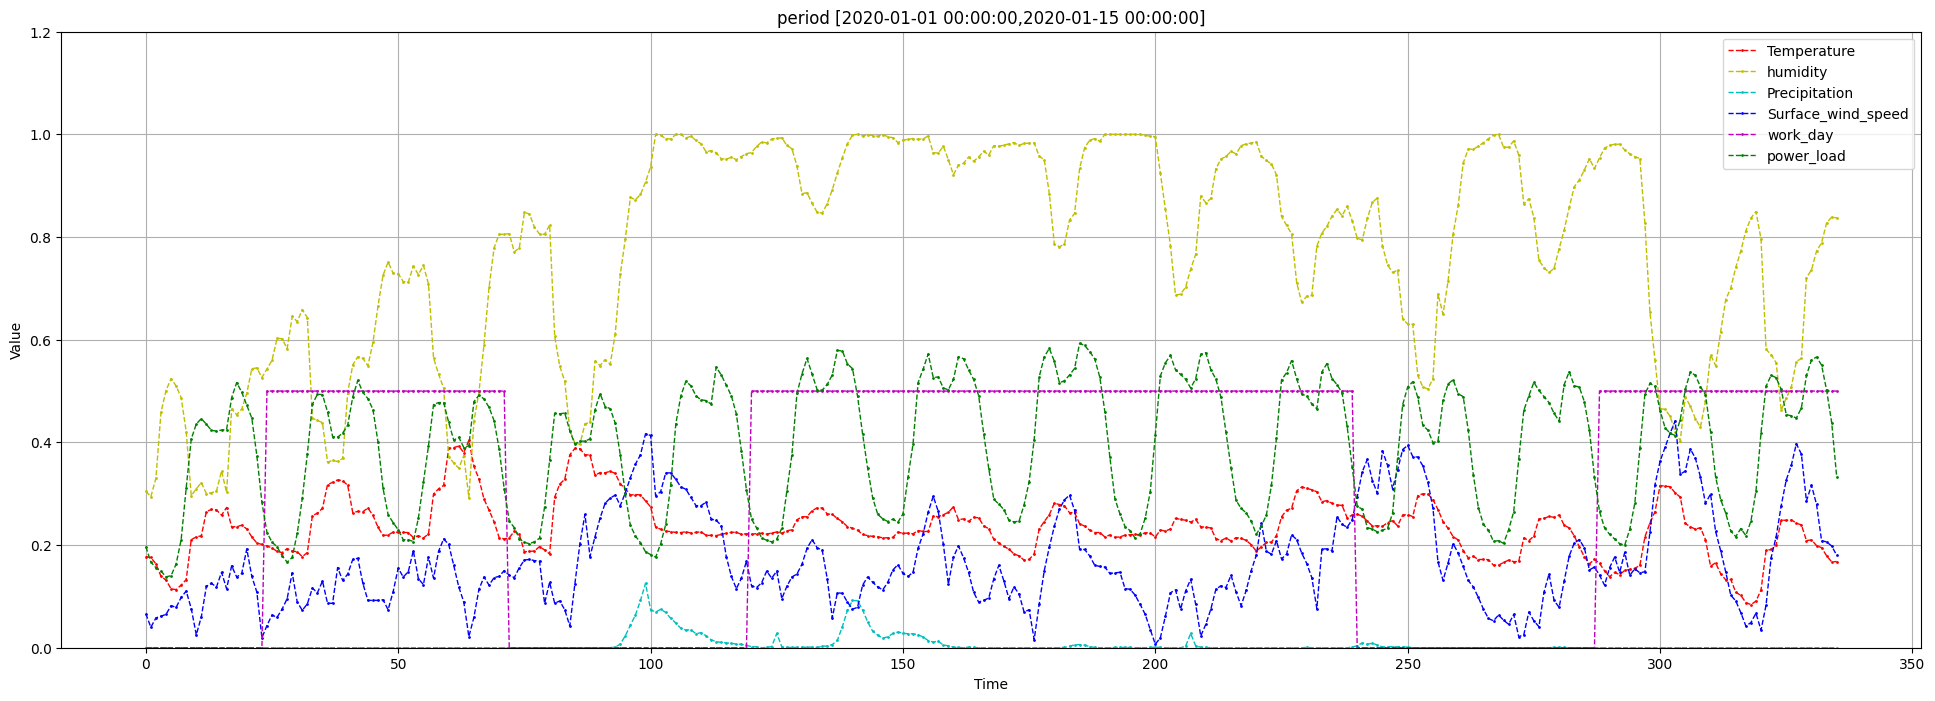

In [47]:
i0 = 24*30*0
i1 = i0+24*14
features = cols
markColors = ['r.--', 'y.--', 'c.--', 'b.--', 'm.--', 'g.--']
plt.rcParams['figure.figsize'] = [24, 8]
for j in range(6):
  plt.plot(data_train[features[j+2]][i0:i1], markColors[j], label=features[j+2], linewidth=1, markersize=2)
plt.title('period [' + str(data.iloc[4*i0].time)+','+str(data.iloc[4*i1].time)+']')
plt.xticks(rotation=0)
plt.ylabel('Value')
plt.xlabel('Time')
plt.ylim([0, 1.2])
plt.grid(True)
plt.legend()
plt.show()

# **Split and Multiframe**

In [48]:
"""## Multiframe data setup"""
"""## 365 * 24 * 4=35,040, 365 * 24=8,760 trainging data set count 305 * 24=7,320"""
def split_sequences(sequences, n_steps, n_prediction):
  X = list();
  n = len(sequences)-n_steps-n_prediction+1
  for i in range(n):
    x = sequences[i:i+n_steps,:]
    X.append(x)
  return array(X)

In [49]:
cols = data.columns.tolist()
print(cols)

['time', 'timeseq', 'Temperature', 'humidity', 'Precipitation', 'Surface_wind_speed', 'work_day', 'power_load']


In [50]:
#features =['timeseq','temperature','humidity','surface_wind_speed','work_day','power_load']
features =['timeseq','Temperature','humidity','Precipitation','Surface_wind_speed','work_day','power_load']
target = 'power_load'
X_train = data_train.loc[:, features].to_numpy()
X_test = data_test.loc[:,features].to_numpy()
n_features = len(features)

In [51]:
print(X_train.shape)
print(X_train)

(17544, 7)
[[0.0000 0.1773 0.3048 0.0000 0.0661 0.0000 0.1968]
 [0.0421 0.1758 0.2943 0.0000 0.0399 0.0000 0.1668]
 [0.0842 0.1632 0.3301 0.0000 0.0581 0.0000 0.1559]
 [0.1263 0.1393 0.4584 0.0000 0.0615 0.0000 0.1493]
 [0.1684 0.1315 0.5010 0.0000 0.0649 0.0000 0.1381]
 [0.2105 0.1148 0.5244 0.0000 0.0820 0.0000 0.1403]
 [0.2526 0.1131 0.5098 0.0000 0.0786 0.0000 0.1630]
 [0.2947 0.1221 0.4874 0.0000 0.0979 0.0000 0.2105]
 [0.3368 0.1327 0.4210 0.0000 0.1105 0.0000 0.3114]
 [0.3789 0.2105 0.2962 0.0000 0.0763 0.0000 0.4065]
 ...
 [0.5895 0.3123 0.3049 0.0000 0.0558 0.5000 0.5640]
 [0.6316 0.3119 0.3072 0.0000 0.0547 0.5000 0.5407]
 [0.6737 0.3333 0.2096 0.0000 0.0216 0.5000 0.5602]
 [0.7158 0.2950 0.3359 0.0000 0.0581 0.5000 0.6178]
 [0.7579 0.2811 0.3832 0.0000 0.0251 0.5000 0.6476]
 [0.8000 0.2608 0.4653 0.0000 0.0604 0.5000 0.6135]
 [0.8421 0.2306 0.5572 0.0000 0.1276 0.5000 0.6197]
 [0.8842 0.2210 0.5781 0.0000 0.1845 0.5000 0.5911]
 [0.9263 0.1860 0.6571 0.0000 0.1982 0.5000 0.53

In [52]:
Y_train = data_train.power_load
Y_test = data_test.power_load

In [53]:
print(Y_train.to_numpy())

[0.1968 0.1668 0.1559 0.1493 0.1381 0.1403 0.1630 0.2105 0.3114 0.4065 ... 0.5640 0.5407 0.5602 0.6178 0.6476 0.6135 0.6197
 0.5911 0.5329 0.4639]


# **Set parameters**

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_steps_1 = 4  # Squence data (48 = 1 day), (720 = 15days), (1440 = 30days)
n_prediction_1 = 1

n_steps_2 = 10
n_prediction_2 = 3

n_steps_3 = 12
n_prediction_3 = 5

np.set_printoptions(edgeitems=10, linewidth=130, formatter=dict(float=lambda x: "%6.4f" % x))

In [55]:
print(X_train, X_train.shape)
print(Y_train)

[[0.0000 0.1773 0.3048 0.0000 0.0661 0.0000 0.1968]
 [0.0421 0.1758 0.2943 0.0000 0.0399 0.0000 0.1668]
 [0.0842 0.1632 0.3301 0.0000 0.0581 0.0000 0.1559]
 [0.1263 0.1393 0.4584 0.0000 0.0615 0.0000 0.1493]
 [0.1684 0.1315 0.5010 0.0000 0.0649 0.0000 0.1381]
 [0.2105 0.1148 0.5244 0.0000 0.0820 0.0000 0.1403]
 [0.2526 0.1131 0.5098 0.0000 0.0786 0.0000 0.1630]
 [0.2947 0.1221 0.4874 0.0000 0.0979 0.0000 0.2105]
 [0.3368 0.1327 0.4210 0.0000 0.1105 0.0000 0.3114]
 [0.3789 0.2105 0.2962 0.0000 0.0763 0.0000 0.4065]
 ...
 [0.5895 0.3123 0.3049 0.0000 0.0558 0.5000 0.5640]
 [0.6316 0.3119 0.3072 0.0000 0.0547 0.5000 0.5407]
 [0.6737 0.3333 0.2096 0.0000 0.0216 0.5000 0.5602]
 [0.7158 0.2950 0.3359 0.0000 0.0581 0.5000 0.6178]
 [0.7579 0.2811 0.3832 0.0000 0.0251 0.5000 0.6476]
 [0.8000 0.2608 0.4653 0.0000 0.0604 0.5000 0.6135]
 [0.8421 0.2306 0.5572 0.0000 0.1276 0.5000 0.6197]
 [0.8842 0.2210 0.5781 0.0000 0.1845 0.5000 0.5911]
 [0.9263 0.1860 0.6571 0.0000 0.1982 0.5000 0.5329]
 [0.968

In [56]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=4, n_prediction=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.n_prediction = n_prediction
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i < self.X.shape[0] - (self.sequence_length + self.n_prediction):
            x = self.X[i:(i + self.sequence_length), :]
        else:
            i = self.X.shape[0] - (self.sequence_length + self.n_prediction)
            x = self.X[i:(i + self.sequence_length), :]
        return x, self.y[i + self.sequence_length + self.n_prediction - 1]

In [57]:
batch_size = 200
train_dataset1 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_1,
    n_prediction = n_prediction_1
)
test_dataset1 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_1,
    n_prediction = n_prediction_1
)

train_dataset2 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_2,
    n_prediction = n_prediction_2
)
test_dataset2 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_2,
    n_prediction = n_prediction_2
)

train_dataset3 = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=n_steps_3,
    n_prediction = n_prediction_3
)
test_dataset3 = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=n_steps_3,
    n_prediction = n_prediction_3
)
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
X1, y1 = next(iter(train_loader1))

print("Features shape:", X1.shape)
print("Target shape:", y1.shape)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)
X2, y2 = next(iter(train_loader2))

print("Features shape:", X2.shape)
print("Target shape:", y2.shape)

train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)
X3, y3 = next(iter(train_loader3))

print("Features shape:", X3.shape)
print("Target shape:", y3.shape)


Features shape: torch.Size([200, 4, 7])
Target shape: torch.Size([200])
Features shape: torch.Size([200, 10, 7])
Target shape: torch.Size([200])
Features shape: torch.Size([200, 12, 7])
Target shape: torch.Size([200])


# **Self_Attention Model**

In [58]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size  # this is the number of features in the input data at each time step
        self.hidden_size = hidden_size  # this is the hidden units in LSTM layer
        self.num_layers = num_layers  # this is the number of LSTM layers
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size, num_layers=self.num_layers, batch_first=True)
          # batch_first= True: input data will have the batch size as the first dimension

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return out

In [59]:
class SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim, num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        # Linear layer
        self.emss = nn.Linear(input_dim, hidden_dim)
        # Attention layer
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=num_heads)
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Attention mechanism
        features = self.emss(x)
        features = features.permute(1, 0, 2)
        query = torch.mean(features, dim=0, keepdim=True)
        #query = query.permute(1, 0, 2)
        attention_output, _ = self.attention(query, features, features)
        # Output layer
        out = self.fc(attention_output.squeeze(0)).flatten()
        return out

In [60]:
class LSTM_SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_heads=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Attention layer
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=num_heads)
        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Forward propagation LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Attention mechanism
        features = out.permute(1, 0, 2)
        query = torch.mean(features, dim=0, keepdim=True)
        #query = query.permute(1, 0, 2)

        attention_output, _ = self.attention(query, features, features)
        # Output layer
        out = self.fc(attention_output.squeeze(0)).flatten()
        return out

# **Training**

In [61]:
input_size =  len(features)
output_size = 1
hidden_units = 8
hidden_units_group = [4]
num_layers = 10 # Hidden layer # 10 3 # 6
num_heads = 8
dropout_prob = 0.5
learning_rate = 0.00125

case_name = 'LSTM_nn_'+str(hidden_units)+'_ln_'+str(num_layers) # case name for graph

In [62]:
train_losses_1 = []
validation_losses_1 = []

train_losses_2 = []
validation_losses_2 = []

train_losses_3 = []
validation_losses_3 = []

train_losses_4 = []
validation_losses_4 = []

train_losses_5 = []
validation_losses_5 = []

train_losses_6 = []
validation_losses_6 = []

train_losses_7 = []
validation_losses_7 = []

train_losses_8 = []
validation_losses_8 = []

train_losses_9 = []
validation_losses_9 = []

best_val_loss = float('inf')

loss_function = nn.MSELoss()

epochs = 300

In [63]:
train_losses_1 = []
validation_losses_1 = []
def train_model(data_loader, model, loss_function,train_losses,optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Train loss: %6.4f  " % avg_loss, end="")

def test_model(data_loader, model, loss_function,validation_losses):
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            # print(X, y)
            output = model(X)
            total_loss += loss_function(output, y).item()
    avg_loss = total_loss / num_batches
    validation_losses.append(avg_loss)
    print(f"Test loss: %6.4f" % avg_loss)

In [125]:
train_losses_1 = []
validation_losses_1 = []
model_LSTM_Model1= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer1 = torch.optim.Adam(model_LSTM_Model1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_LSTM_Model1, loss_function, train_losses_1,optimizer=optimizer1)
    test_model(test_loader1, model_LSTM_Model1, loss_function,validation_losses_1)


torch.save(model_LSTM_Model1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp1_MSE.pth')

Epoch 0 Train loss: 0.0141  Test loss: 0.0147
Epoch 1 Train loss: 0.0078  Test loss: 0.0079
Epoch 2 Train loss: 0.0043  Test loss: 0.0035
Epoch 3 Train loss: 0.0024  Test loss: 0.0028
Epoch 4 Train loss: 0.0019  Test loss: 0.0023
Epoch 5 Train loss: 0.0016  Test loss: 0.0020
Epoch 6 Train loss: 0.0014  Test loss: 0.0017
Epoch 7 Train loss: 0.0012  Test loss: 0.0015
Epoch 8 Train loss: 0.0011  Test loss: 0.0014
Epoch 9 Train loss: 0.0009  Test loss: 0.0012
Epoch 10 Train loss: 0.0009  Test loss: 0.0011
Epoch 11 Train loss: 0.0008  Test loss: 0.0010
Epoch 12 Train loss: 0.0008  Test loss: 0.0010
Epoch 13 Train loss: 0.0007  Test loss: 0.0010
Epoch 14 Train loss: 0.0007  Test loss: 0.0009
Epoch 15 Train loss: 0.0007  Test loss: 0.0009
Epoch 16 Train loss: 0.0006  Test loss: 0.0009
Epoch 17 Train loss: 0.0006  Test loss: 0.0009
Epoch 18 Train loss: 0.0006  Test loss: 0.0009
Epoch 19 Train loss: 0.0006  Test loss: 0.0008
Epoch 20 Train loss: 0.0006  Test loss: 0.0008
Epoch 21 Train loss: 0.

In [127]:
train_losses_2 = []
validation_losses_2 = []
model_LSTM_Model2= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer2 = torch.optim.Adam(model_LSTM_Model2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_LSTM_Model2, loss_function, train_losses_2,optimizer=optimizer2)
    test_model(test_loader2, model_LSTM_Model2, loss_function,validation_losses_2)


torch.save(model_LSTM_Model2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp2_MSE.pth')

Epoch 0 Train loss: 0.0590  Test loss: 0.0219
Epoch 1 Train loss: 0.0132  Test loss: 0.0197
Epoch 2 Train loss: 0.0120  Test loss: 0.0175
Epoch 3 Train loss: 0.0107  Test loss: 0.0149
Epoch 4 Train loss: 0.0093  Test loss: 0.0125
Epoch 5 Train loss: 0.0077  Test loss: 0.0099
Epoch 6 Train loss: 0.0059  Test loss: 0.0078
Epoch 7 Train loss: 0.0046  Test loss: 0.0068
Epoch 8 Train loss: 0.0041  Test loss: 0.0067
Epoch 9 Train loss: 0.0039  Test loss: 0.0065
Epoch 10 Train loss: 0.0038  Test loss: 0.0064
Epoch 11 Train loss: 0.0037  Test loss: 0.0062
Epoch 12 Train loss: 0.0036  Test loss: 0.0062
Epoch 13 Train loss: 0.0035  Test loss: 0.0062
Epoch 14 Train loss: 0.0035  Test loss: 0.0060
Epoch 15 Train loss: 0.0034  Test loss: 0.0060
Epoch 16 Train loss: 0.0034  Test loss: 0.0060
Epoch 17 Train loss: 0.0033  Test loss: 0.0059
Epoch 18 Train loss: 0.0033  Test loss: 0.0058
Epoch 19 Train loss: 0.0032  Test loss: 0.0059
Epoch 20 Train loss: 0.0032  Test loss: 0.0058
Epoch 21 Train loss: 0.

In [66]:
train_losses_3 = []
validation_losses_3 = []
model_LSTM_Model3= LSTMModel(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers).to(device)

optimizer3 = torch.optim.Adam(model_LSTM_Model3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_LSTM_Model3, loss_function, train_losses_3,optimizer=optimizer3)
    test_model(test_loader3, model_LSTM_Model3, loss_function,validation_losses_3)


torch.save(model_LSTM_Model3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_setp3_MSE.pth')

Epoch 0 Train loss: 0.0129  Test loss: 0.0150
Epoch 1 Train loss: 0.0050  Test loss: 0.0066
Epoch 2 Train loss: 0.0036  Test loss: 0.0063
Epoch 3 Train loss: 0.0033  Test loss: 0.0059
Epoch 4 Train loss: 0.0030  Test loss: 0.0053
Epoch 5 Train loss: 0.0027  Test loss: 0.0055
Epoch 6 Train loss: 0.0025  Test loss: 0.0048
Epoch 7 Train loss: 0.0022  Test loss: 0.0047
Epoch 8 Train loss: 0.0021  Test loss: 0.0043
Epoch 9 Train loss: 0.0020  Test loss: 0.0042
Epoch 10 Train loss: 0.0018  Test loss: 0.0041
Epoch 11 Train loss: 0.0017  Test loss: 0.0044
Epoch 12 Train loss: 0.0017  Test loss: 0.0041
Epoch 13 Train loss: 0.0016  Test loss: 0.0038
Epoch 14 Train loss: 0.0016  Test loss: 0.0041
Epoch 15 Train loss: 0.0016  Test loss: 0.0038
Epoch 16 Train loss: 0.0015  Test loss: 0.0039
Epoch 17 Train loss: 0.0015  Test loss: 0.0040
Epoch 18 Train loss: 0.0015  Test loss: 0.0039
Epoch 19 Train loss: 0.0015  Test loss: 0.0038
Epoch 20 Train loss: 0.0015  Test loss: 0.0035
Epoch 21 Train loss: 0.

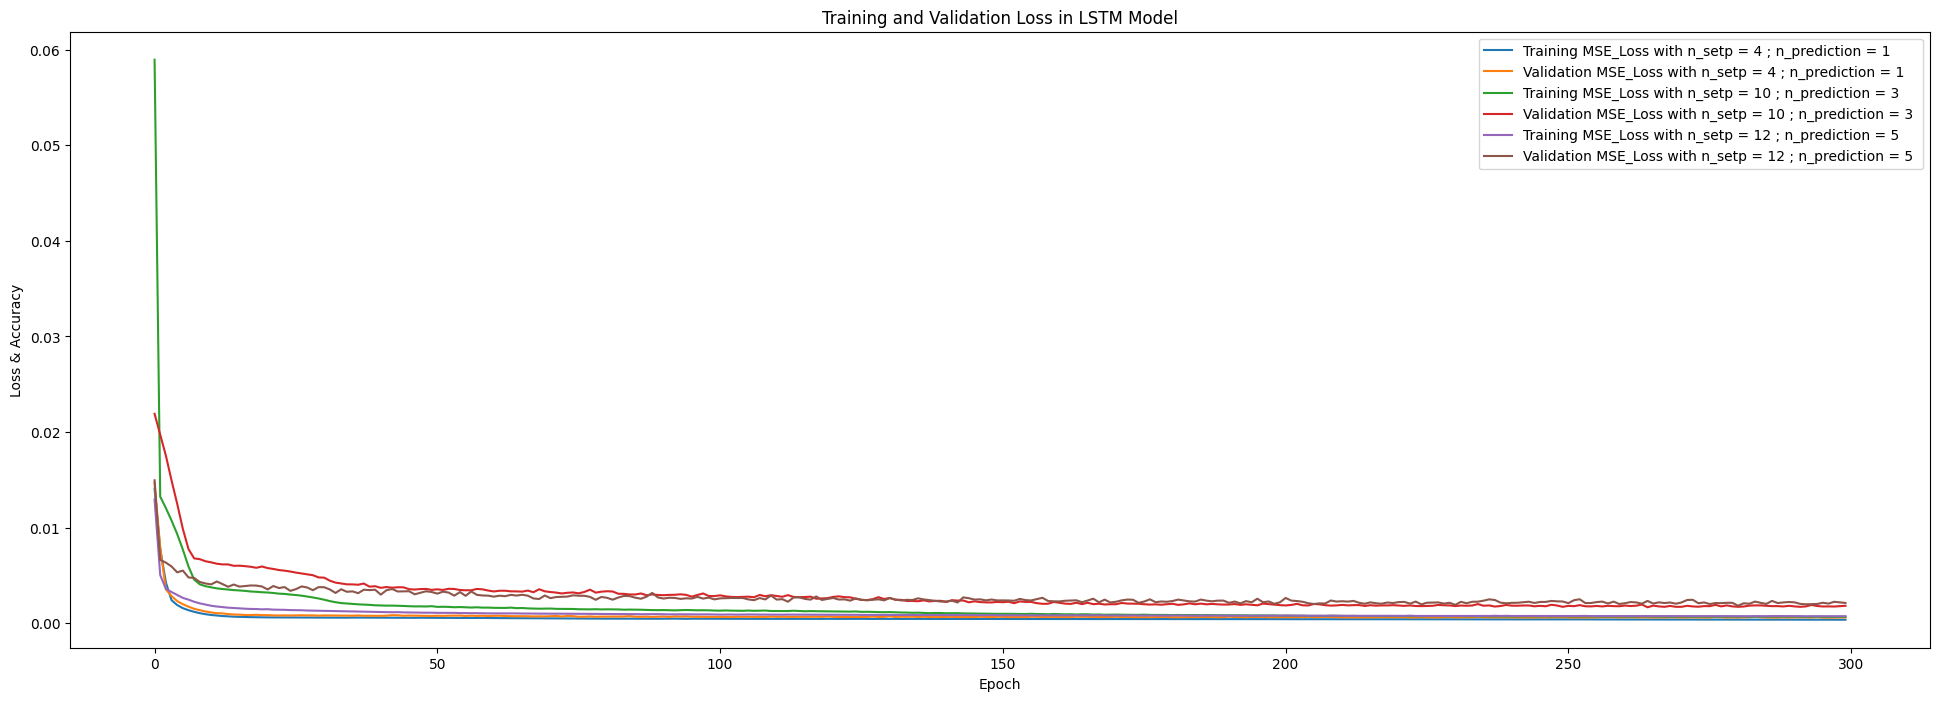

In [128]:
plt.figure()
plt.plot(train_losses_1, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_1, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_2, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_2, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_3, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_3, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in LSTM Model')
plt.legend()
plt.show()

In [91]:
train_losses_4 = []
validation_losses_4 = []
model_LSTM_SelfAttentionModel1= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=num_heads).to(device)

optimizer1 = torch.optim.Adam(model_LSTM_SelfAttentionModel1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_LSTM_SelfAttentionModel1, loss_function, train_losses_4,optimizer=optimizer1)
    test_model(test_loader1, model_LSTM_SelfAttentionModel1, loss_function,validation_losses_4)


torch.save(model_LSTM_SelfAttentionModel1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp1_MSE.pth')

Epoch 0 Train loss: 0.0984  Test loss: 0.0262
Epoch 1 Train loss: 0.0153  Test loss: 0.0251
Epoch 2 Train loss: 0.0153  Test loss: 0.0255
Epoch 3 Train loss: 0.0153  Test loss: 0.0255
Epoch 4 Train loss: 0.0153  Test loss: 0.0252
Epoch 5 Train loss: 0.0153  Test loss: 0.0252
Epoch 6 Train loss: 0.0153  Test loss: 0.0261
Epoch 7 Train loss: 0.0153  Test loss: 0.0246
Epoch 8 Train loss: 0.0153  Test loss: 0.0246
Epoch 9 Train loss: 0.0153  Test loss: 0.0250
Epoch 10 Train loss: 0.0153  Test loss: 0.0245
Epoch 11 Train loss: 0.0153  Test loss: 0.0242
Epoch 12 Train loss: 0.0153  Test loss: 0.0245
Epoch 13 Train loss: 0.0135  Test loss: 0.0128
Epoch 14 Train loss: 0.0060  Test loss: 0.0047
Epoch 15 Train loss: 0.0020  Test loss: 0.0017
Epoch 16 Train loss: 0.0011  Test loss: 0.0014
Epoch 17 Train loss: 0.0009  Test loss: 0.0011
Epoch 18 Train loss: 0.0008  Test loss: 0.0010
Epoch 19 Train loss: 0.0007  Test loss: 0.0010
Epoch 20 Train loss: 0.0007  Test loss: 0.0009
Epoch 21 Train loss: 0.

In [108]:
train_losses_5 = []
validation_losses_5 = []
model_LSTM_SelfAttentionModel2= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=num_heads).to(device)

optimizer2 = torch.optim.Adam(model_LSTM_SelfAttentionModel2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_LSTM_SelfAttentionModel2, loss_function, train_losses_5,optimizer=optimizer2)
    test_model(test_loader2, model_LSTM_SelfAttentionModel2, loss_function,validation_losses_5)


torch.save(model_LSTM_SelfAttentionModel2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp2_MSE.pth')

Epoch 0 Train loss: 0.0163  Test loss: 0.0255
Epoch 1 Train loss: 0.0153  Test loss: 0.0252
Epoch 2 Train loss: 0.0153  Test loss: 0.0250
Epoch 3 Train loss: 0.0153  Test loss: 0.0250
Epoch 4 Train loss: 0.0153  Test loss: 0.0247
Epoch 5 Train loss: 0.0153  Test loss: 0.0249
Epoch 6 Train loss: 0.0153  Test loss: 0.0259
Epoch 7 Train loss: 0.0153  Test loss: 0.0252
Epoch 8 Train loss: 0.0153  Test loss: 0.0250
Epoch 9 Train loss: 0.0153  Test loss: 0.0243
Epoch 10 Train loss: 0.0127  Test loss: 0.0166
Epoch 11 Train loss: 0.0048  Test loss: 0.0088
Epoch 12 Train loss: 0.0034  Test loss: 0.0066
Epoch 13 Train loss: 0.0030  Test loss: 0.0062
Epoch 14 Train loss: 0.0028  Test loss: 0.0057
Epoch 15 Train loss: 0.0025  Test loss: 0.0053
Epoch 16 Train loss: 0.0024  Test loss: 0.0055
Epoch 17 Train loss: 0.0022  Test loss: 0.0051
Epoch 18 Train loss: 0.0020  Test loss: 0.0046
Epoch 19 Train loss: 0.0019  Test loss: 0.0042
Epoch 20 Train loss: 0.0018  Test loss: 0.0045
Epoch 21 Train loss: 0.

In [70]:
train_losses_6 = []
validation_losses_6 = []
model_LSTM_SelfAttentionModel3= LSTM_SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units, num_layers=num_layers, output_dim=output_size,num_heads=num_heads).to(device)

optimizer3 = torch.optim.Adam(model_LSTM_SelfAttentionModel3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_LSTM_SelfAttentionModel3, loss_function, train_losses_6,optimizer=optimizer3)
    test_model(test_loader3, model_LSTM_SelfAttentionModel3, loss_function,validation_losses_6)


torch.save(model_LSTM_SelfAttentionModel3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_LSTM_SA_setp3_MSE.pth')

Epoch 0 Train loss: 0.0727  Test loss: 0.0250
Epoch 1 Train loss: 0.0153  Test loss: 0.0251
Epoch 2 Train loss: 0.0153  Test loss: 0.0242
Epoch 3 Train loss: 0.0153  Test loss: 0.0247
Epoch 4 Train loss: 0.0153  Test loss: 0.0244
Epoch 5 Train loss: 0.0153  Test loss: 0.0247
Epoch 6 Train loss: 0.0153  Test loss: 0.0249
Epoch 7 Train loss: 0.0152  Test loss: 0.0239
Epoch 8 Train loss: 0.0102  Test loss: 0.0123
Epoch 9 Train loss: 0.0044  Test loss: 0.0056
Epoch 10 Train loss: 0.0026  Test loss: 0.0050
Epoch 11 Train loss: 0.0022  Test loss: 0.0046
Epoch 12 Train loss: 0.0020  Test loss: 0.0045
Epoch 13 Train loss: 0.0020  Test loss: 0.0045
Epoch 14 Train loss: 0.0019  Test loss: 0.0041
Epoch 15 Train loss: 0.0018  Test loss: 0.0042
Epoch 16 Train loss: 0.0018  Test loss: 0.0045
Epoch 17 Train loss: 0.0017  Test loss: 0.0040
Epoch 18 Train loss: 0.0017  Test loss: 0.0040
Epoch 19 Train loss: 0.0016  Test loss: 0.0039
Epoch 20 Train loss: 0.0016  Test loss: 0.0039
Epoch 21 Train loss: 0.

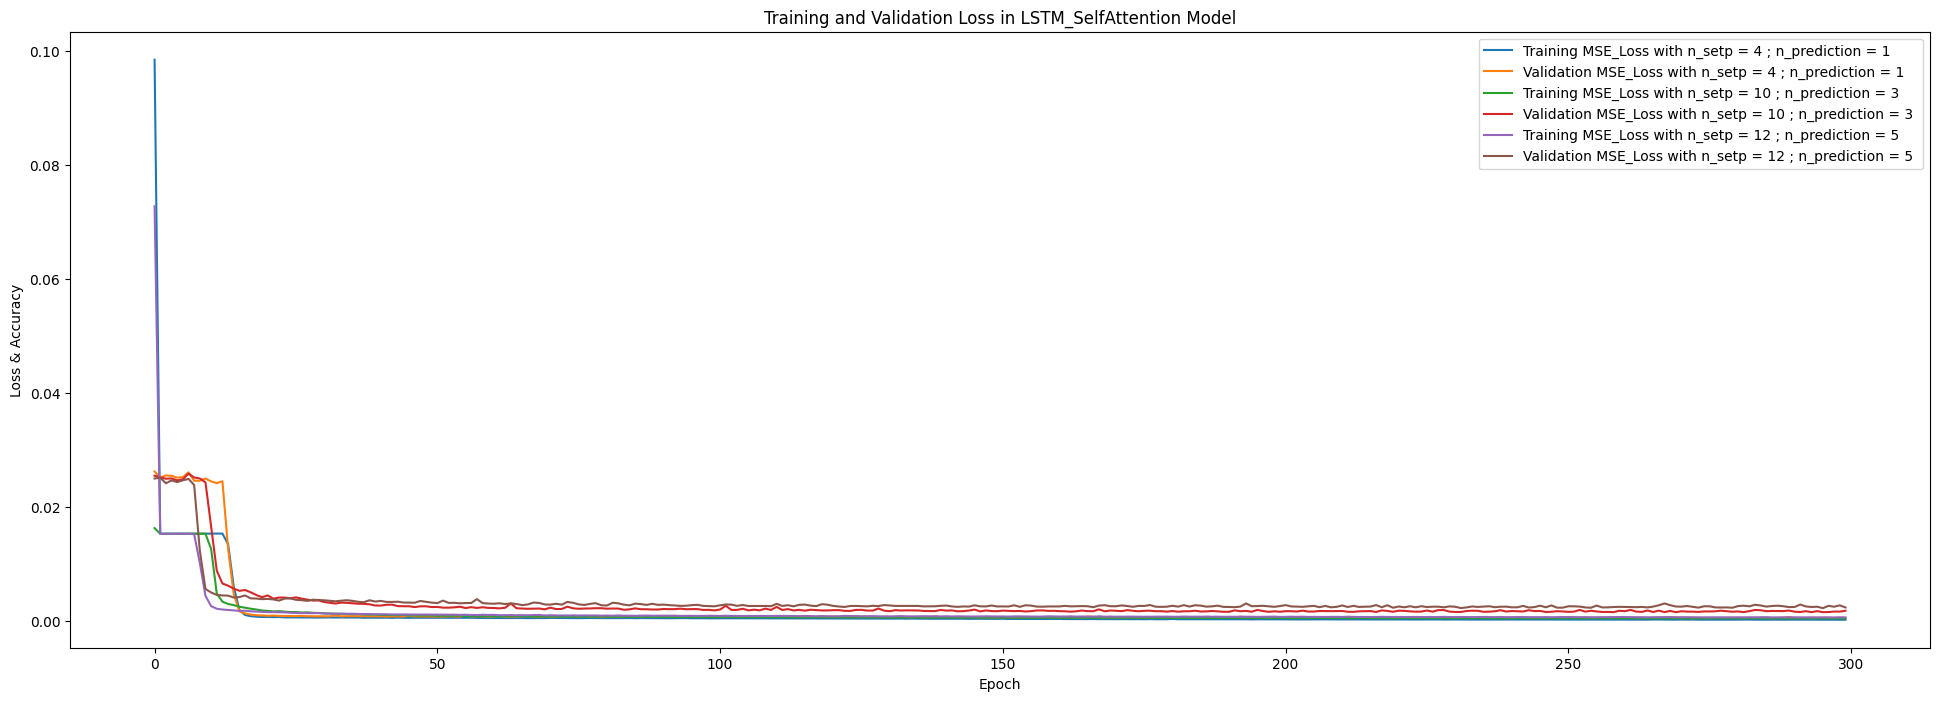

In [109]:
plt.figure()
plt.plot(train_losses_4, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_4, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_5, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_5, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_6, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_6, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in LSTM_SelfAttention Model')
plt.legend()
plt.show()

In [72]:
train_losses_7 = []
validation_losses_7 = []
model_SelfAttentionModel1= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units,output_dim=output_size,num_heads=num_heads).to(device)

optimizer1 = torch.optim.Adam(model_SelfAttentionModel1.parameters(), lr=learning_rate)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader1, model_SelfAttentionModel1, loss_function, train_losses_7,optimizer=optimizer1)
    test_model(test_loader1, model_SelfAttentionModel1, loss_function,validation_losses_7)


torch.save(model_SelfAttentionModel1.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp1_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp1_MSE.pth')

Epoch 0 Train loss: 0.0253  Test loss: 0.0167
Epoch 1 Train loss: 0.0096  Test loss: 0.0120
Epoch 2 Train loss: 0.0063  Test loss: 0.0056
Epoch 3 Train loss: 0.0033  Test loss: 0.0039
Epoch 4 Train loss: 0.0028  Test loss: 0.0038
Epoch 5 Train loss: 0.0028  Test loss: 0.0038
Epoch 6 Train loss: 0.0028  Test loss: 0.0039
Epoch 7 Train loss: 0.0027  Test loss: 0.0036
Epoch 8 Train loss: 0.0026  Test loss: 0.0035
Epoch 9 Train loss: 0.0025  Test loss: 0.0032
Epoch 10 Train loss: 0.0022  Test loss: 0.0031
Epoch 11 Train loss: 0.0020  Test loss: 0.0027
Epoch 12 Train loss: 0.0018  Test loss: 0.0024
Epoch 13 Train loss: 0.0016  Test loss: 0.0021
Epoch 14 Train loss: 0.0014  Test loss: 0.0020
Epoch 15 Train loss: 0.0013  Test loss: 0.0018
Epoch 16 Train loss: 0.0012  Test loss: 0.0017
Epoch 17 Train loss: 0.0012  Test loss: 0.0016
Epoch 18 Train loss: 0.0011  Test loss: 0.0015
Epoch 19 Train loss: 0.0011  Test loss: 0.0015
Epoch 20 Train loss: 0.0010  Test loss: 0.0014
Epoch 21 Train loss: 0.

In [73]:
train_losses_8 = []
validation_losses_8 = []
model_SelfAttentionModel2= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units,output_dim=output_size,num_heads=num_heads).to(device)

optimizer2 = torch.optim.Adam(model_SelfAttentionModel2.parameters(), lr=learning_rate)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader2, model_SelfAttentionModel2, loss_function, train_losses_8,optimizer=optimizer2)
    test_model(test_loader2, model_SelfAttentionModel2, loss_function,validation_losses_8)


torch.save(model_SelfAttentionModel2.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp2_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp2_MSE.pth')

Epoch 0 Train loss: 0.0159  Test loss: 0.0199
Epoch 1 Train loss: 0.0079  Test loss: 0.0075
Epoch 2 Train loss: 0.0041  Test loss: 0.0075
Epoch 3 Train loss: 0.0040  Test loss: 0.0071
Epoch 4 Train loss: 0.0039  Test loss: 0.0070
Epoch 5 Train loss: 0.0038  Test loss: 0.0068
Epoch 6 Train loss: 0.0037  Test loss: 0.0069
Epoch 7 Train loss: 0.0036  Test loss: 0.0069
Epoch 8 Train loss: 0.0036  Test loss: 0.0065
Epoch 9 Train loss: 0.0035  Test loss: 0.0065
Epoch 10 Train loss: 0.0035  Test loss: 0.0064
Epoch 11 Train loss: 0.0035  Test loss: 0.0064
Epoch 12 Train loss: 0.0034  Test loss: 0.0065
Epoch 13 Train loss: 0.0034  Test loss: 0.0063
Epoch 14 Train loss: 0.0033  Test loss: 0.0064
Epoch 15 Train loss: 0.0033  Test loss: 0.0062
Epoch 16 Train loss: 0.0033  Test loss: 0.0062
Epoch 17 Train loss: 0.0033  Test loss: 0.0063
Epoch 18 Train loss: 0.0032  Test loss: 0.0059
Epoch 19 Train loss: 0.0032  Test loss: 0.0060
Epoch 20 Train loss: 0.0031  Test loss: 0.0058
Epoch 21 Train loss: 0.

In [74]:
train_losses_9 = []
validation_losses_9 = []
model_SelfAttentionModel3= SelfAttentionModel(input_dim=input_size, hidden_dim=hidden_units,output_dim=output_size,num_heads=num_heads).to(device)

optimizer3 = torch.optim.Adam(model_SelfAttentionModel3.parameters(), lr=learning_rate)

scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=10, factor=0.9, verbose=True)

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch} ", end="")
    train_model(train_loader3, model_SelfAttentionModel3, loss_function, train_losses_9,optimizer=optimizer3)
    test_model(test_loader3, model_SelfAttentionModel3, loss_function,validation_losses_9)


torch.save(model_SelfAttentionModel3.state_dict(), '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp3_MSE.pth')
print("Save in:", '/content/drive/MyDrive/Topics/PL2023/data/net_SAM_setp3_MSE.pth')

Epoch 0 Train loss: 0.0667  Test loss: 0.0188
Epoch 1 Train loss: 0.0123  Test loss: 0.0170
Epoch 2 Train loss: 0.0113  Test loss: 0.0150
Epoch 3 Train loss: 0.0101  Test loss: 0.0134
Epoch 4 Train loss: 0.0084  Test loss: 0.0109
Epoch 5 Train loss: 0.0064  Test loss: 0.0079
Epoch 6 Train loss: 0.0045  Test loss: 0.0059
Epoch 7 Train loss: 0.0035  Test loss: 0.0057
Epoch 8 Train loss: 0.0032  Test loss: 0.0056
Epoch 9 Train loss: 0.0031  Test loss: 0.0057
Epoch 10 Train loss: 0.0031  Test loss: 0.0055
Epoch 11 Train loss: 0.0030  Test loss: 0.0054
Epoch 12 Train loss: 0.0030  Test loss: 0.0054
Epoch 13 Train loss: 0.0029  Test loss: 0.0053
Epoch 14 Train loss: 0.0029  Test loss: 0.0052
Epoch 15 Train loss: 0.0028  Test loss: 0.0050
Epoch 16 Train loss: 0.0028  Test loss: 0.0050
Epoch 17 Train loss: 0.0027  Test loss: 0.0049
Epoch 18 Train loss: 0.0027  Test loss: 0.0048
Epoch 19 Train loss: 0.0027  Test loss: 0.0048
Epoch 20 Train loss: 0.0026  Test loss: 0.0047
Epoch 21 Train loss: 0.

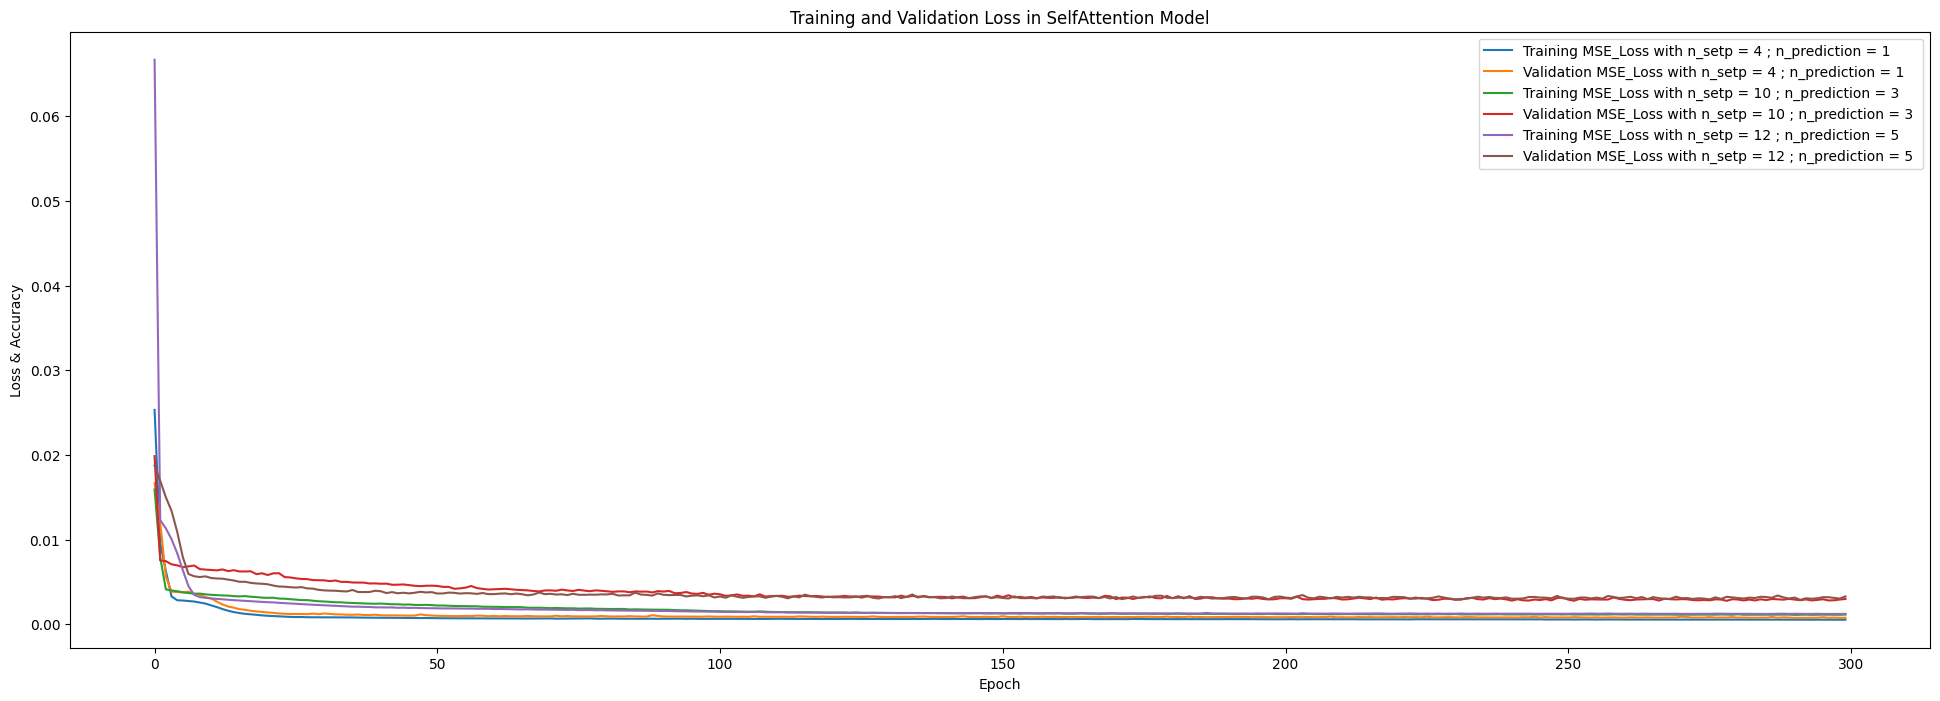

In [75]:
plt.figure()
plt.plot(train_losses_7, label='Training MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(validation_losses_7, label='Validation MSE_Loss with n_setp = 4 ; n_prediction = 1 ')
plt.plot(train_losses_8, label='Training MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(validation_losses_8, label='Validation MSE_Loss with n_setp = 10 ; n_prediction = 3 ')
plt.plot(train_losses_9, label='Training MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.plot(validation_losses_9, label='Validation MSE_Loss with n_setp = 12 ; n_prediction = 5 ')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss in SelfAttention Model')
plt.legend()
plt.show()

# **Prediction result**

In [129]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

In [130]:
Y_train1 = data_train.power_load
rY_train1 = np.roll(Y_train1, -(n_steps_1 + n_prediction_1-1))
rY_train1[-(n_steps_1+n_prediction_1-1):] = 0

Y_train2 = data_train.power_load
rY_train2 = np.roll(Y_train1, -(n_steps_2 + n_prediction_2-1))
rY_train2[-(n_steps_2+n_prediction_2-1):] = 0

Y_train3 = data_train.power_load
rY_train3 = np.roll(Y_train1, -(n_steps_3 + n_prediction_3-1))
rY_train3[-(n_steps_3+n_prediction_3-1):] = 0

print(Y_train1)
print(rY_train1)
print(Y_train2)
print(rY_train2)
print(Y_train3)
print(rY_train3)

0       0.1968
1       0.1668
2       0.1559
3       0.1493
4       0.1381
         ...  
17539   0.6135
17540   0.6197
17541   0.5911
17542   0.5329
17543   0.4639
Name: power_load, Length: 17544, dtype: float64
[0.1381 0.1403 0.1630 0.2105 0.3114 0.4065 0.4359 0.4464 0.4353 0.4234 ... 0.6476 0.6135 0.6197 0.5911 0.5329 0.4639 0.0000
 0.0000 0.0000 0.0000]
0       0.1968
1       0.1668
2       0.1559
3       0.1493
4       0.1381
         ...  
17539   0.6135
17540   0.6197
17541   0.5911
17542   0.5329
17543   0.4639
Name: power_load, Length: 17544, dtype: float64
[0.4353 0.4234 0.4220 0.4241 0.4250 0.4871 0.5165 0.4978 0.4726 0.4473 ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000]
0       0.1968
1       0.1668
2       0.1559
3       0.1493
4       0.1381
         ...  
17539   0.6135
17540   0.6197
17541   0.5911
17542   0.5329
17543   0.4639
Name: power_load, Length: 17544, dtype: float64
[0.4250 0.4871 0.5165 0.4978 0.4726 0.4473 0.3738 0.2832 0.2244 0.2

In [131]:
Y_test1 = data_test.power_load
rY_test1 = np.roll(Y_test1, -(n_steps_1 + n_prediction_1-1))
rY_test1[-(n_steps_1 + n_prediction_1 - 1):] = 0

Y_test2 = data_test.power_load
rY_test2 = np.roll(Y_test2, -(n_steps_2 + n_prediction_2-1))
rY_test2[-(n_steps_2 + n_prediction_2 - 1):] = 0

Y_test3 = data_test.power_load
rY_test3 = np.roll(Y_test3, -(n_steps_3 + n_prediction_3-1))
rY_test3[-(n_steps_3 + n_prediction_3 - 1):] = 0

print(Y_test1)
print(rY_test1)
print(Y_test2)
print(rY_test2)
print(Y_test3)
print(rY_test3)

17544   0.4007
17545   0.3755
17546   0.3531
17547   0.3291
17548   0.3105
         ...  
26299   0.5912
26300   0.5849
26301   0.5608
26302   0.5123
26303   0.4312
Name: power_load, Length: 8760, dtype: float64
[0.3105 0.3020 0.3288 0.3650 0.4407 0.4813 0.4710 0.4574 0.4276 0.3689 ... 0.6213 0.5912 0.5849 0.5608 0.5123 0.4312 0.0000
 0.0000 0.0000 0.0000]
17544   0.4007
17545   0.3755
17546   0.3531
17547   0.3291
17548   0.3105
         ...  
26299   0.5912
26300   0.5849
26301   0.5608
26302   0.5123
26303   0.4312
Name: power_load, Length: 8760, dtype: float64
[0.4276 0.3689 0.3513 0.3585 0.3966 0.4973 0.5745 0.5713 0.5610 0.5265 ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000]
17544   0.4007
17545   0.3755
17546   0.3531
17547   0.3291
17548   0.3105
         ...  
26299   0.5912
26300   0.5849
26301   0.5608
26302   0.5123
26303   0.4312
Name: power_load, Length: 8760, dtype: float64
[0.3966 0.4973 0.5745 0.5713 0.5610 0.5265 0.4824 0.3978 0.3473 0.3241

In [132]:
ystar_col = "Model forecast"
train_eval_loader1 = DataLoader(train_dataset1, batch_size=100, shuffle=False)
train_eval_loader2 = DataLoader(train_dataset2, batch_size=100, shuffle=False)
train_eval_loader3 = DataLoader(train_dataset3, batch_size=100, shuffle=False)

dt_train1 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test1 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train2 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test2 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train3 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test3 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train4 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test4 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train5 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test5 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train6 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test6 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train7 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test7 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train8 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test8 = subdata[subdata.time.between(period_test[0], period_test[1])]
dt_train9 = subdata[subdata.time.between(period_train[0], period_train[1])]
dt_test9 = subdata[subdata.time.between(period_test[0], period_test[1])]


dt_train1[ystar_col] = predict(train_eval_loader1, model_LSTM_Model1).numpy()
dt_test1[ystar_col] = predict(test_loader1, model_LSTM_Model1).numpy()
dt_train2[ystar_col] = predict(train_eval_loader2, model_LSTM_Model2).numpy()
dt_test2[ystar_col] = predict(test_loader2, model_LSTM_Model2).numpy()
dt_train3[ystar_col] = predict(train_eval_loader3, model_LSTM_Model3).numpy()
dt_test3[ystar_col] = predict(test_loader3, model_LSTM_Model3).numpy()
dt_train4[ystar_col] = predict(train_eval_loader1, model_LSTM_SelfAttentionModel1).numpy()
dt_test4[ystar_col] = predict(test_loader1, model_LSTM_SelfAttentionModel1).numpy()
dt_train5[ystar_col] = predict(train_eval_loader2, model_LSTM_SelfAttentionModel2).numpy()
dt_test5[ystar_col] = predict(test_loader2, model_LSTM_SelfAttentionModel2).numpy()
dt_train6[ystar_col] = predict(train_eval_loader3, model_LSTM_SelfAttentionModel3).numpy()
dt_test6[ystar_col] = predict(test_loader3, model_LSTM_SelfAttentionModel3).numpy()
dt_train7[ystar_col] = predict(train_eval_loader1, model_SelfAttentionModel1).numpy()
dt_test7[ystar_col] = predict(test_loader1, model_SelfAttentionModel1).numpy()
dt_train8[ystar_col] = predict(train_eval_loader2, model_SelfAttentionModel2).numpy()
dt_test8[ystar_col] = predict(test_loader2, model_SelfAttentionModel2).numpy()
dt_train9[ystar_col] = predict(train_eval_loader3, model_SelfAttentionModel3).numpy()
dt_test9[ystar_col] = predict(test_loader3, model_SelfAttentionModel3).numpy()


n1 = 500
n2 = n1+batch_size

print(rY_train1[n1 :n2])
print(rY_train2[n1 :n2])
print(rY_train3[n1 :n2])
print(dt_train1[ystar_col][n1 :n2])
print(dt_train2[ystar_col][n1 :n2])
print(dt_train3[ystar_col][n1 :n2])
print(dt_train4[ystar_col][n1 :n2])
print(dt_train5[ystar_col][n1 :n2])
print(dt_train6[ystar_col][n1 :n2])
print(dt_train7[ystar_col][n1 :n2])
print(dt_train8[ystar_col][n1 :n2])
print(dt_train9[ystar_col][n1 :n2])
print(rY_test1[n1 :n2])
print(rY_test2[n1 :n2])
print(rY_test3[n1 :n2])
print(dt_test1[ystar_col][n1 :n2])
print(dt_test2[ystar_col][n1 :n2])
print(dt_test3[ystar_col][n1 :n2])
print(dt_test4[ystar_col][n1 :n2])
print(dt_test5[ystar_col][n1 :n2])
print(dt_test6[ystar_col][n1 :n2])
print(dt_test7[ystar_col][n1 :n2])
print(dt_test8[ystar_col][n1 :n2])
print(dt_test9[ystar_col][n1 :n2])

<ipython-input-132-f4f2226357de>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train1[ystar_col] = predict(train_eval_loader1, model_LSTM_Model1).numpy()
<ipython-input-132-f4f2226357de>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test1[ystar_col] = predict(test_loader1, model_LSTM_Model1).numpy()
<ipython-input-132-f4f2226357de>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

[0.2308 0.1966 0.1630 0.1609 0.1653 0.1483 0.1584 0.1917 0.2827 0.3694 0.3820 0.3744 0.3887 0.3575 0.3258 0.2834 0.2695 0.3362
 0.4042 0.4201 0.4079 0.4042 0.3655 0.3007 0.2164 0.1740 0.1491 0.1329 0.1250 0.1171 0.1248 0.1480 0.2463 0.3355 0.3213 0.3222
 0.3502 0.3311 0.3049 0.2807 0.2710 0.3482 0.4028 0.4038 0.4083 0.3983 0.3525 0.2598 0.1755 0.1295 0.0990 0.0813 0.0845 0.0748
 0.0798 0.1074 0.1887 0.2814 0.3041 0.3177 0.3443 0.3176 0.2983 0.2778 0.2901 0.3489 0.3921 0.4077 0.3853 0.3633 0.3540 0.3010
 0.2411 0.1526 0.0984 0.0757 0.0599 0.0554 0.0809 0.1081 0.1957 0.2520 0.2797 0.3137 0.3320 0.2532 0.2177 0.2055 0.2079 0.2650
 0.3526 0.3388 0.3175 0.2964 0.2527 0.1799 0.1241 0.0832 0.0711 0.0485 0.0452 0.0421 0.0520 0.0672 0.1355 0.2357 0.2715 0.2979
 0.3315 0.2764 0.2611 0.2485 0.2576 0.3079 0.3646 0.3587 0.3410 0.3168 0.2589 0.1845 0.1284 0.0903 0.0705 0.0680 0.0478 0.0561
 0.0646 0.0710 0.1431 0.2075 0.2291 0.2483 0.2887 0.2285 0.2004 0.1793 0.1916 0.2713 0.3497 0.3471 0.3272 0.304

<ipython-input-132-f4f2226357de>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train9[ystar_col] = predict(train_eval_loader3, model_SelfAttentionModel3).numpy()
<ipython-input-132-f4f2226357de>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test9[ystar_col] = predict(test_loader3, model_SelfAttentionModel3).numpy()


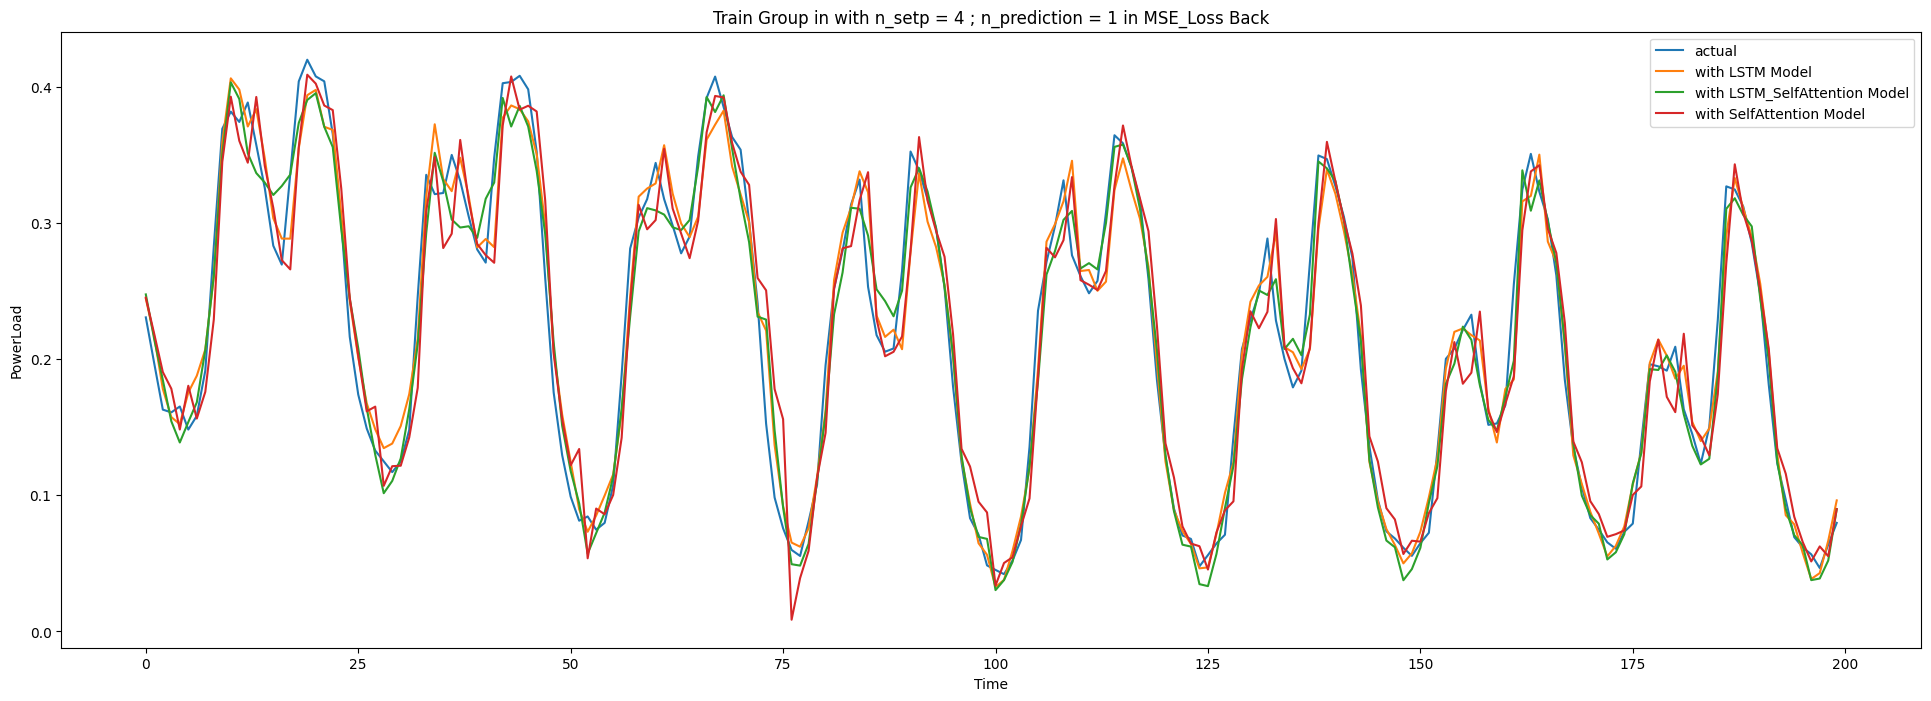

In [133]:
plt.plot(rY_train1[n1 :n2], label='actual' )
plt.plot(dt_train1[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train4[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train7[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 4 ; n_prediction = 1 in MSE_Loss Back' )
plt.legend()
plt.show()

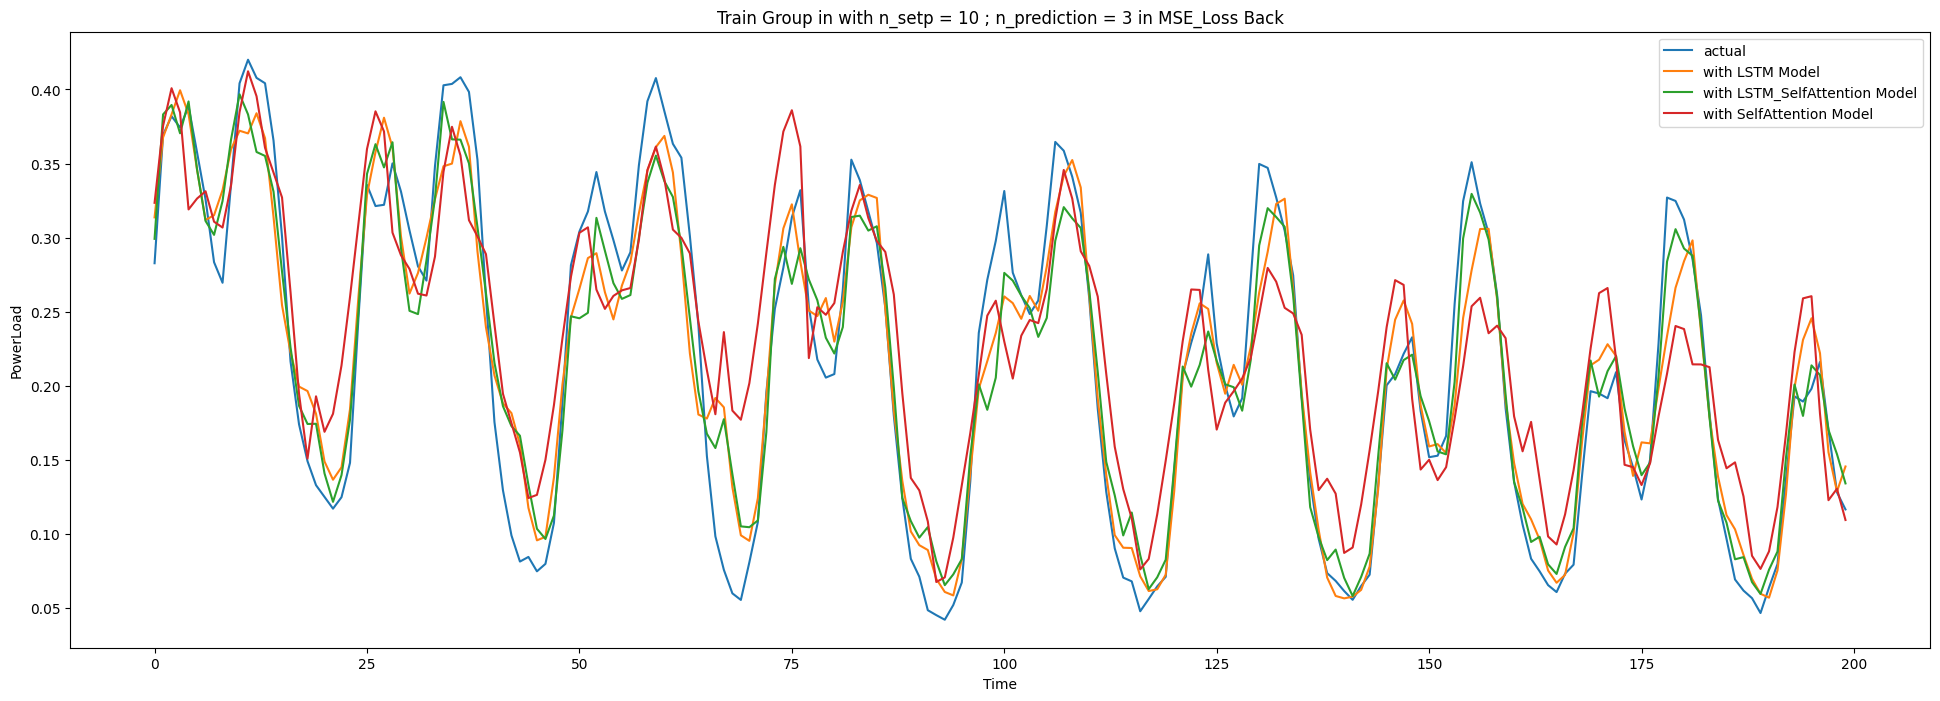

In [134]:
plt.plot(rY_train2[n1 :n2], label='actual' )
plt.plot(dt_train2[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train5[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train8[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 10 ; n_prediction = 3 in MSE_Loss Back' )
plt.legend()
plt.show()

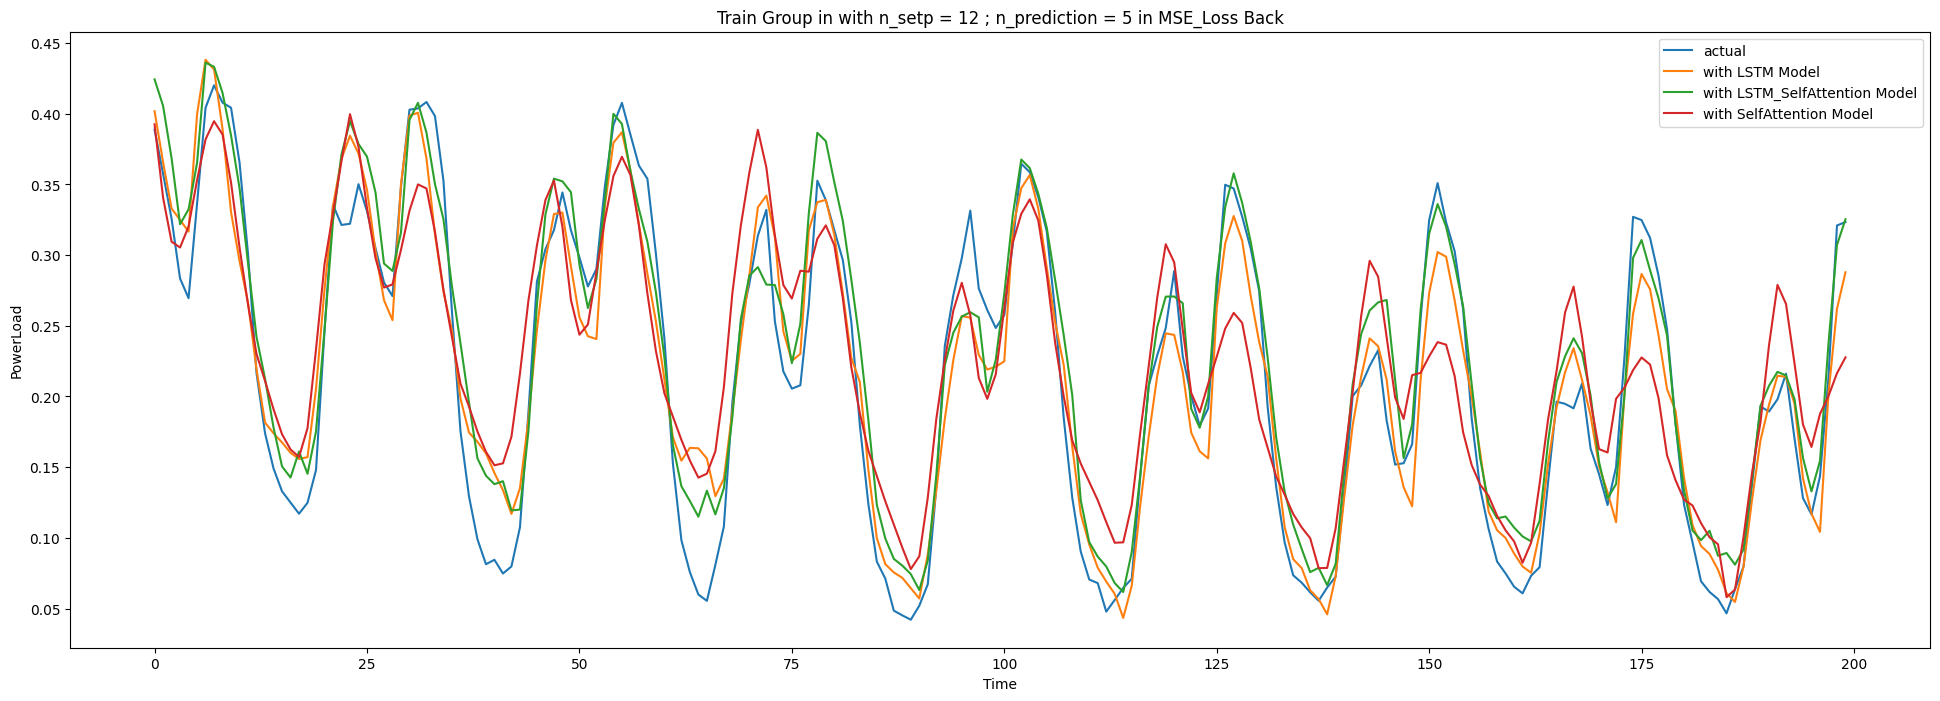

In [135]:
plt.plot(rY_train3[n1 :n2], label='actual' )
plt.plot(dt_train3[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_train6[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_train9[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Train Group in with n_setp = 12 ; n_prediction = 5 in MSE_Loss Back')
plt.legend()
plt.show()

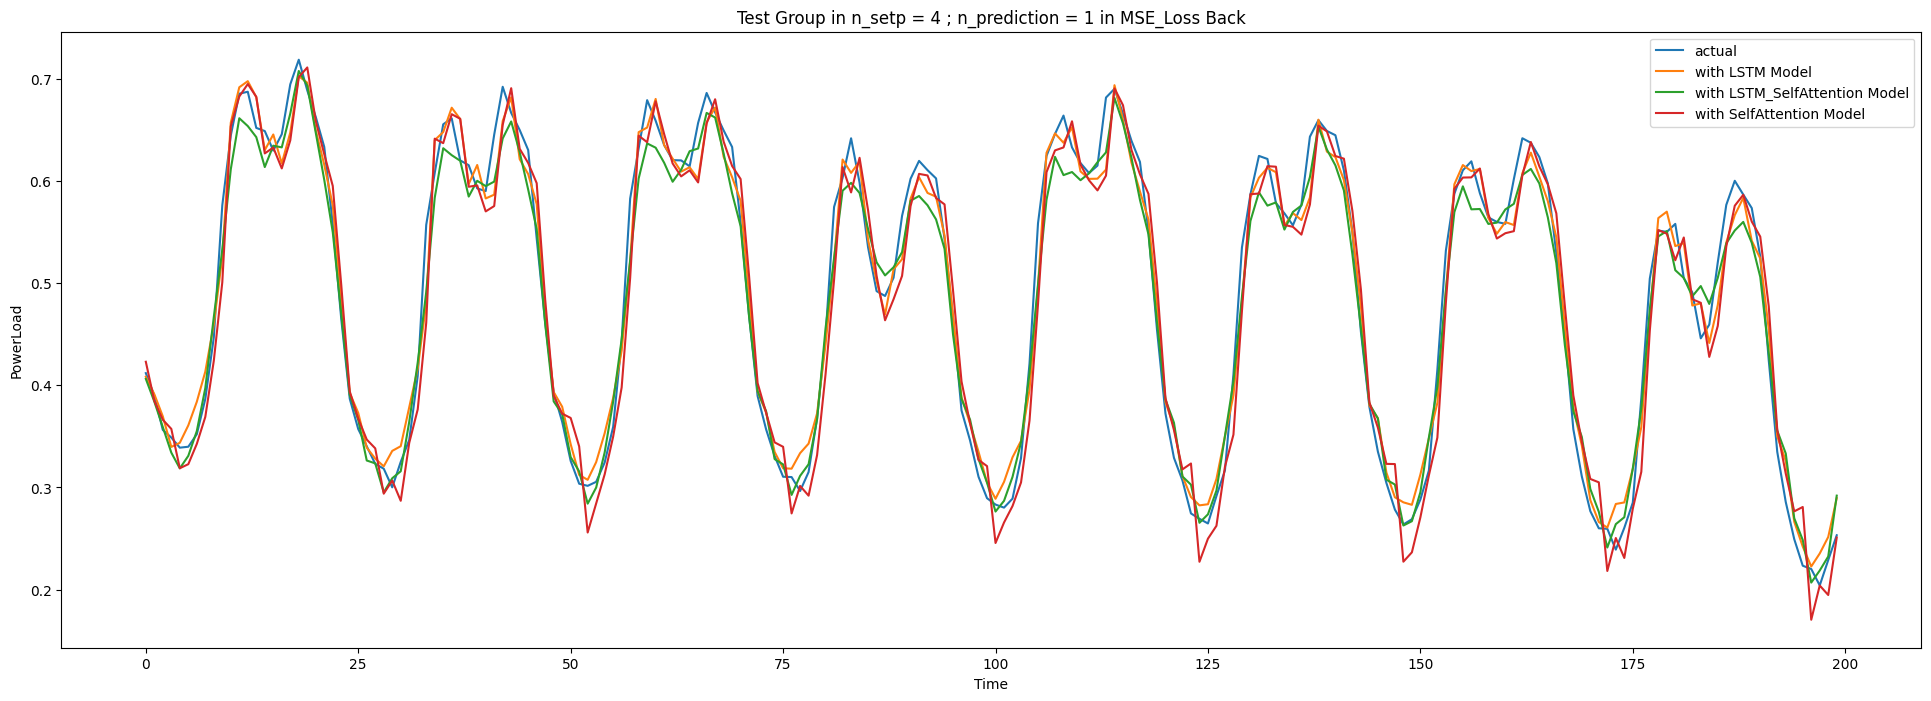

In [136]:
plt.plot(rY_test1[n1 :n2], label='actual' )
plt.plot(dt_test1[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test4[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test7[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in n_setp = 4 ; n_prediction = 1 in MSE_Loss Back')
plt.legend()
plt.show()

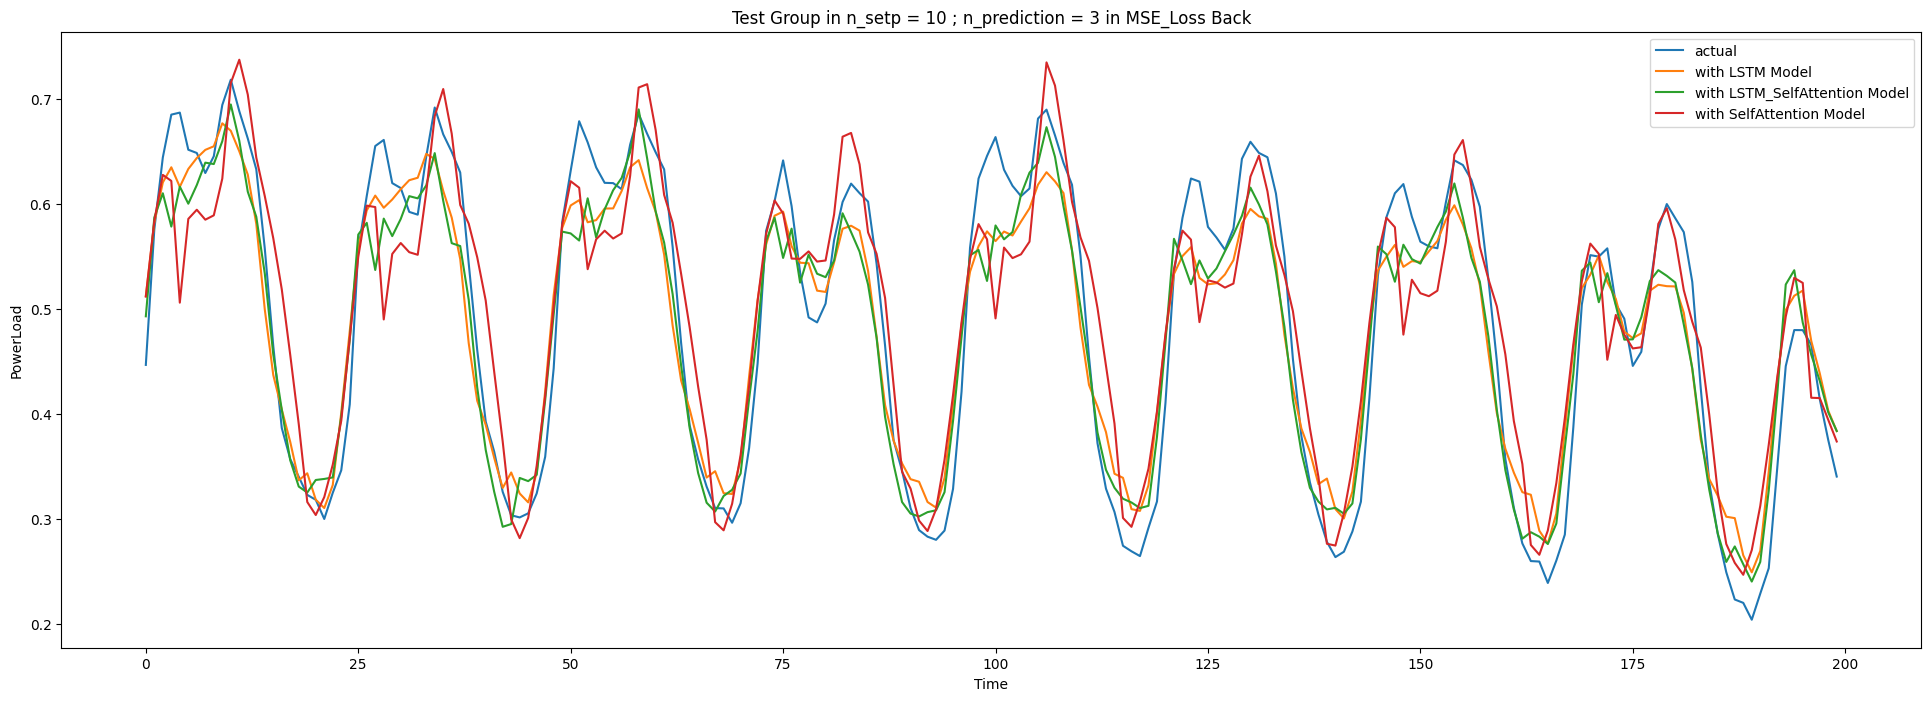

In [137]:
plt.plot(rY_test2[n1 :n2], label='actual' )
plt.plot(dt_test2[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test5[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test8[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in n_setp = 10 ; n_prediction = 3 in MSE_Loss Back')
plt.legend()
plt.show()

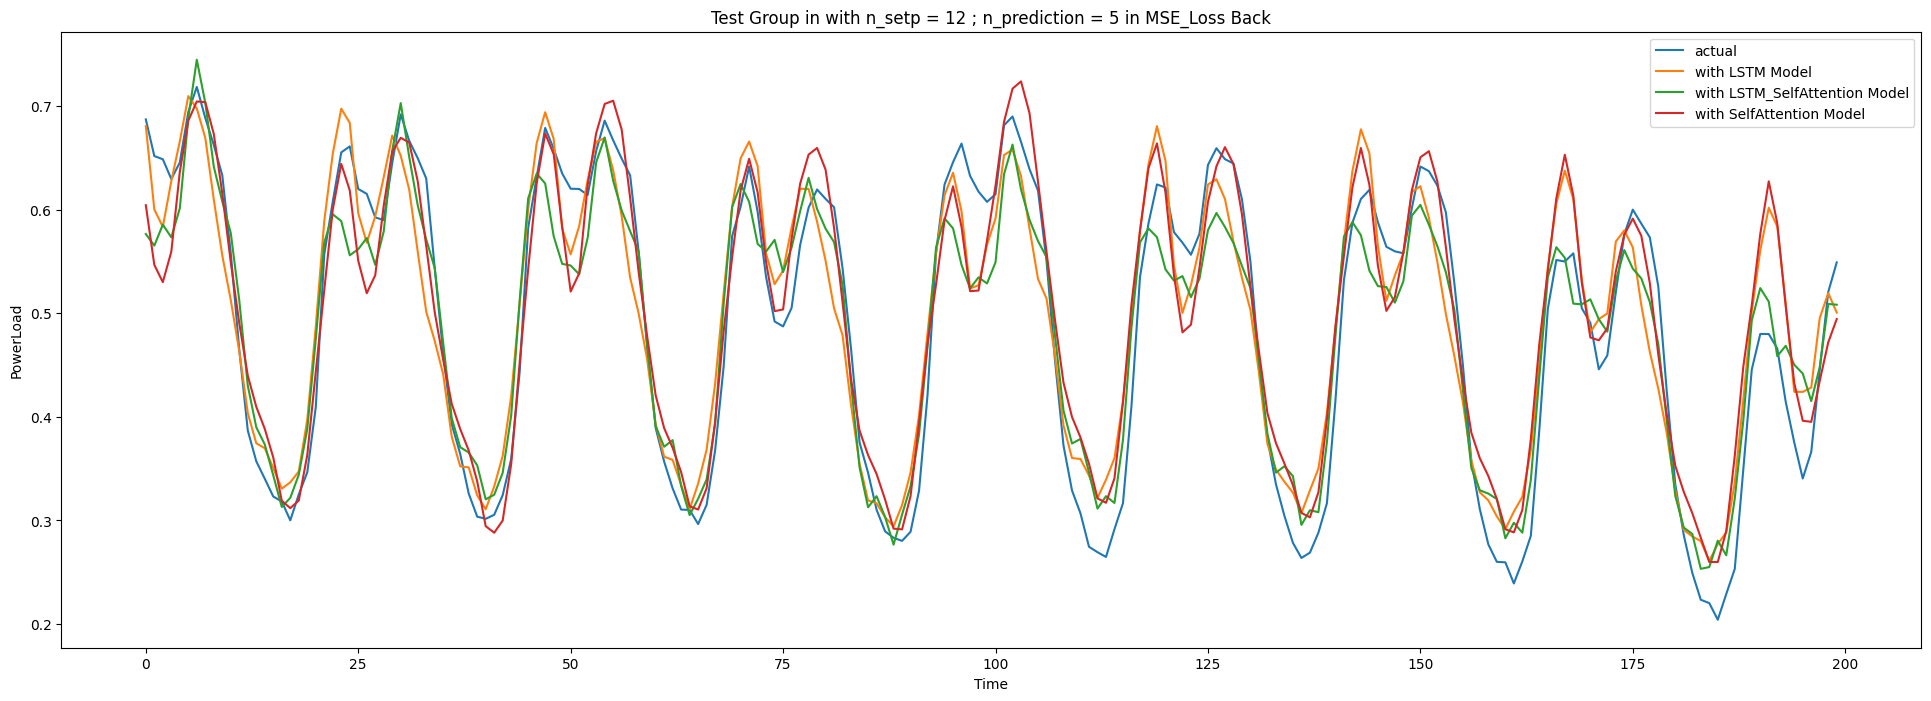

In [138]:
plt.plot(rY_test3[n1 :n2], label='actual' )
plt.plot(dt_test3[ystar_col][n1:n2].to_list(), label='with LSTM Model')
plt.plot(dt_test6[ystar_col][n1:n2].to_list(), label='with LSTM_SelfAttention Model')
plt.plot(dt_test9[ystar_col][n1:n2].to_list(), label='with SelfAttention Model')
plt.xlabel('Time')
plt.ylabel('PowerLoad')
plt.title('Test Group in with n_setp = 12 ; n_prediction = 5 in MSE_Loss Back')
plt.legend()
plt.show()

In [139]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def MAPE(y_true, y_pred):
    actual, pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


RMSE OF LSTM MODEL : 0.0240
RMSE OF LSTM MODEL : 0.0339
RMSE OF LSTM MODEL : 0.0336
RMSE OF Self-Attention MODEL : 0.0309
RMSE OF Self-Attention MODEL : 0.0548
RMSE OF Self-Attention MODEL : 0.0526
RMSE OF LSTM_SA MODEL : 0.0210
RMSE OF LSTM_SA MODEL : 0.0316
RMSE OF LSTM_SA MODEL : 0.0313


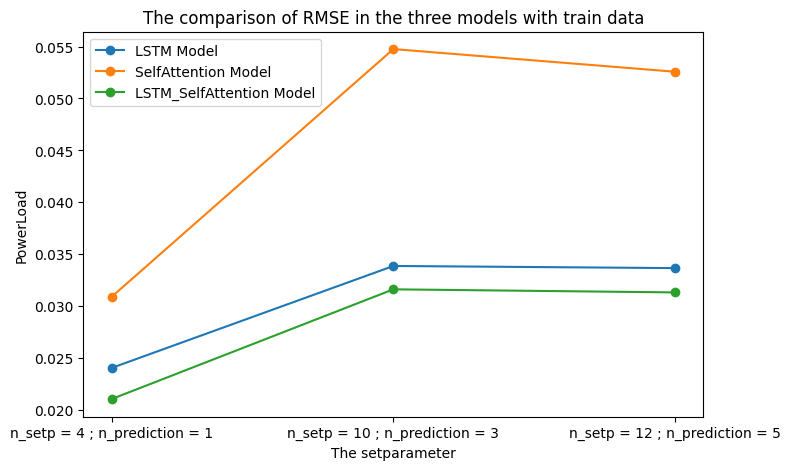

In [140]:
LSTM_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train1[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_1:.4f}")
LSTM_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train2[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_2:.4f}")
LSTM_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train3[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_3:.4f}")

SA_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train7[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_1:.4f}")
SA_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train8[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_2:.4f}")
SA_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train9[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_3:.4f}")

LSTM_SA_RMSE_1 = RMSE(rY_train1[n1 :n2], dt_train4[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_1:.4f}")
LSTM_SA_RMSE_2 = RMSE(rY_train2[n1 :n2], dt_train5[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_2:.4f}")
LSTM_SA_RMSE_3 = RMSE(rY_train3[n1 :n2], dt_train6[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_3:.4f}")

L = [LSTM_RMSE_1,LSTM_RMSE_2,LSTM_RMSE_3]
S = [SA_RMSE_1,SA_RMSE_2,SA_RMSE_3]
LS = [LSTM_SA_RMSE_1,LSTM_SA_RMSE_2,LSTM_SA_RMSE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of RMSE in the three models with train data')
plt.legend()
plt.show()

MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : 9.7247 %
MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : 15.6531 %
MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : 17.7048 %
MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : 14.1143 %
MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : 33.8277 %
MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : 30.6957 %
MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : 9.2971 %
MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : 16.1729 %
MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : 18.9821 %


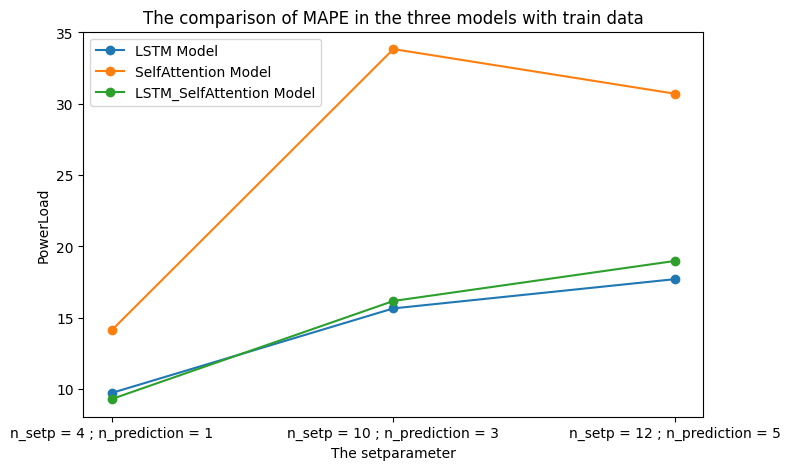

In [144]:
LSTM_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train1[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_MAPE_1:.4f} %")
LSTM_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train2[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_MAPE_2:.4f} %")
LSTM_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train3[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_MAPE_3:.4f} %")

SA_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train7[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : {SA_MAPE_1:.4f} %")
SA_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train8[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : {SA_MAPE_2:.4f} %")
SA_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train9[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : {SA_MAPE_3:.4f} %")

LSTM_SA_MAPE_1 = MAPE(rY_train1[n1 :n2], dt_train4[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_SA_MAPE_1:.4f} %")
LSTM_SA_MAPE_2 = MAPE(rY_train2[n1 :n2], dt_train5[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_SA_MAPE_2:.4f} %")
LSTM_SA_MAPE_3 = MAPE(rY_train3[n1 :n2], dt_train6[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_SA_MAPE_3:.4f} %")

L = [LSTM_MAPE_1,LSTM_MAPE_2,LSTM_MAPE_3]
S = [SA_MAPE_1,SA_MAPE_2,SA_MAPE_3]
LS = [LSTM_SA_MAPE_1,LSTM_SA_MAPE_2,LSTM_SA_MAPE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of MAPE in the three models with train data')
plt.legend()
plt.show()

RMSE OF LSTM MODEL : 0.0247
RMSE OF LSTM MODEL : 0.0471
RMSE OF LSTM MODEL : 0.0516
RMSE OF Self-Attention MODEL : 0.0319
RMSE OF Self-Attention MODEL : 0.0576
RMSE OF Self-Attention MODEL : 0.0482
RMSE OF LSTM_SA MODEL : 0.0243
RMSE OF LSTM_SA MODEL : 0.0453
RMSE OF LSTM_SA MODEL : 0.0460


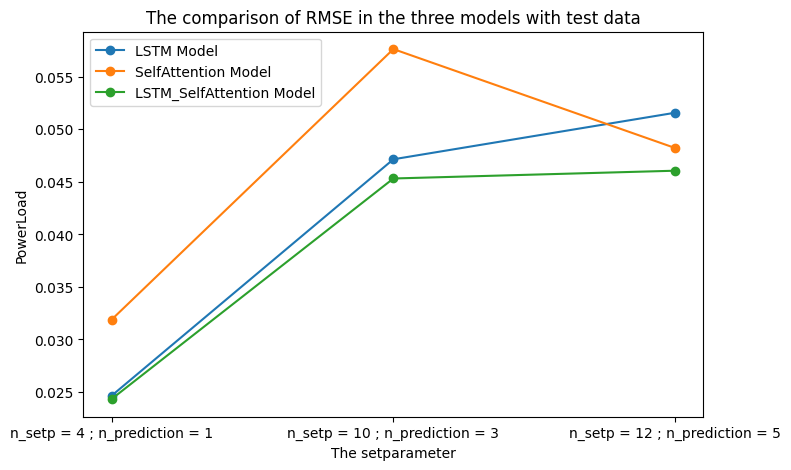

In [142]:
LSTM_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test1[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_1:.4f}")
LSTM_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test2[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_2:.4f}")
LSTM_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test3[ystar_col][n1 :n2])
print(f"RMSE OF LSTM MODEL : {LSTM_RMSE_3:.4f}")

SA_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test7[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_1:.4f}")
SA_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test8[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_2:.4f}")
SA_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test9[ystar_col][n1 :n2])
print(f"RMSE OF Self-Attention MODEL : {SA_RMSE_3:.4f}")

LSTM_SA_RMSE_1 = RMSE(rY_test1[n1 :n2], dt_test4[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_1:.4f}")
LSTM_SA_RMSE_2 = RMSE(rY_test2[n1 :n2], dt_test5[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_2:.4f}")
LSTM_SA_RMSE_3 = RMSE(rY_test3[n1 :n2], dt_test6[ystar_col][n1 :n2])
print(f"RMSE OF LSTM_SA MODEL : {LSTM_SA_RMSE_3:.4f}")

L = [LSTM_RMSE_1,LSTM_RMSE_2,LSTM_RMSE_3]
S = [SA_RMSE_1,SA_RMSE_2,SA_RMSE_3]
LS = [LSTM_SA_RMSE_1,LSTM_SA_RMSE_2,LSTM_SA_RMSE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of RMSE in the three models with test data')
plt.legend()
plt.show()

MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : 4.4789 %
MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : 9.1150 %
MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : 9.9936 %
MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : 5.8438 %
MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : 10.6281 %
MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : 9.2157 %
MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : 4.1437 %
MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : 8.0461 %
MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : 8.7157 %


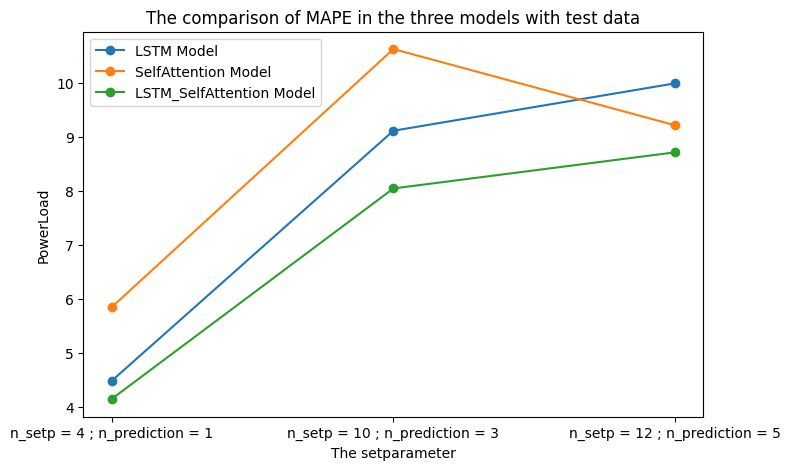

In [143]:
LSTM_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test1[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_MAPE_1:.4f} %")
LSTM_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test2[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_MAPE_2:.4f} %")
LSTM_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test3[ystar_col][n1 :n2])
print(f"MAPE OF LSTM MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_MAPE_3:.4f} %")

SA_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test7[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 4 ; n_prediction = 1 : {SA_MAPE_1:.4f} %")
SA_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test8[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 10 ; n_prediction = 3 : {SA_MAPE_2:.4f} %")
SA_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test9[ystar_col][n1 :n2])
print(f"MAPE OF Self-Attention MODEL in with n_setp = 12 ; n_prediction = 5 : {SA_MAPE_3:.4f} %")

LSTM_SA_MAPE_1 = MAPE(rY_test1[n1 :n2], dt_test4[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 4 ; n_prediction = 1 : {LSTM_SA_MAPE_1:.4f} %")
LSTM_SA_MAPE_2 = MAPE(rY_test2[n1 :n2], dt_test5[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 10 ; n_prediction = 3 : {LSTM_SA_MAPE_2:.4f} %")
LSTM_SA_MAPE_3 = MAPE(rY_test3[n1 :n2], dt_test6[ystar_col][n1 :n2])
print(f"MAPE OF LSTM_SA MODEL in with n_setp = 12 ; n_prediction = 5 : {LSTM_SA_MAPE_3:.4f} %")

L = [LSTM_MAPE_1,LSTM_MAPE_2,LSTM_MAPE_3]
S = [SA_MAPE_1,SA_MAPE_2,SA_MAPE_3]
LS = [LSTM_SA_MAPE_1,LSTM_SA_MAPE_2,LSTM_SA_MAPE_3]

group = ["n_setp = 4 ; n_prediction = 1","n_setp = 10 ; n_prediction = 3","n_setp = 12 ; n_prediction = 5"]
plt.figure(figsize=(8,5))
plt.plot(group,L, label='LSTM Model', marker="o")
plt.plot(group,S, label='SelfAttention Model', marker="o")
plt.plot(group,LS, label='LSTM_SelfAttention Model', marker="o")
plt.xlabel('The setparameter')
plt.ylabel('PowerLoad')
plt.title('The comparison of MAPE in the three models with test data')
plt.legend()
plt.show()